In [109]:
# https://nsidc.org/data/smap_l1_l3_anc_static/versions/1
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import os

# Configuration

In [111]:
data_dir = r"G:\Araki\SMSigxSMAP\1_data"
fn = os.path.join(data_dir, r"SPL3SMP\SMAP_L3_SM_P_20150331_R18290_001.h5")

In [119]:
out_dir = os.path.join(data_dir, 'SPL3SMP_datarods')
if ~os.path.exists(out_dir):
    os.makedirs(out_dir)

# Investigate netCDF4 file

In [2]:
ncf = netCDF4.Dataset(fn, diskless=True, persist=False)
nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

In [9]:
nch_am.variables

{'EASE_column_index': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_column_index(phony_dim_0, phony_dim_1)
     long_name: The column index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 963
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_AM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'EASE_row_index': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_row_index(phony_dim_0, phony_dim_1)
     long_name: The row index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 405
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_AM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'albedo': <class 'netCDF4._netCDF4.Variable'>
 float32

In [10]:
nch_pm.variables

{'EASE_column_index_pm': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_column_index_pm(phony_dim_3, phony_dim_4)
     long_name: The column index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 963
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_PM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'EASE_row_index_pm': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_row_index_pm(phony_dim_3, phony_dim_4)
     long_name: The row index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 405
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_PM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'albedo_dca_pm': <class 'netCDF4._netCDF4.

# Prepare geocoordinate matrix 

In [102]:
# Return as regular numpy array rather than masked array
_latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
_longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
_EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
_EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

In [106]:
# Coordinates with no data are skipped --- fill them
latitude = np.nanmax(_latitude, axis=1)
EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
longitude = np.nanmax(_longitude, axis=0)
EASE_column_index = np.nanmax(_EASE_column_index, axis=0)

In [120]:
coord_info_column = pd.DataFrame({"latitude":latitude, "EASE_column_index":EASE_row_index})
coord_info_row = pd.DataFrame({"longitude":longitude, "EASE_row_index":EASE_column_index})
coord_info_column.to_csv(os.path.join(out_dir, 'coord_info_column.csv'))
coord_info_row.to_csv(os.path.join(out_dir, 'coord_info_row.csv'))

# Read SMAP files

In [128]:
xds_am = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture','retrieval_qual_flag','surface_flag'])
xds_pm = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_PM', variable=['soil_moisture_pm','retrieval_qual_flag_pm','surface_flag_pm'])
time = xds_am.Metadata_Extent_rangeBeginningDateTime 
xds_am

<xarray.Dataset>
Dimensions:                                              (band: 1, y: 406,
                                                          x: 964)
Coordinates:
  * band                                                 (band) int32 1
    spatial_ref                                          int32 ...
Dimensions without coordinates: y, x
Data variables:
    Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag  (band, y, x) float32 ...
    Soil_Moisture_Retrieval_Data_AM_soil_moisture        (band, y, x) float32 ...
    Soil_Moisture_Retrieval_Data_AM_surface_flag         (band, y, x) float32 ...
Attributes: (12/698)
    Metadata_AcquisitionInformation_platformDocument_edition:                ...
    Metadata_AcquisitionInformation_platformDocument_publicationDate:        ...
    Metadata_AcquisitionInformation_platformDocument_title:                  ...
    Metadata_AcquisitionInformation_platform_antennaRotationRate:            ...
    Metadata_AcquisitionInformation_platform_description:                    ...
    Metadata_AcquisitionInformation_platform_identifier:                     ...
    ...                                                                          ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_coordinates: ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_long_name:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_units:       ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_max:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_min:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm__FillValue:  ...

# Read landcover dataset (have different dimensions from other data)

c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


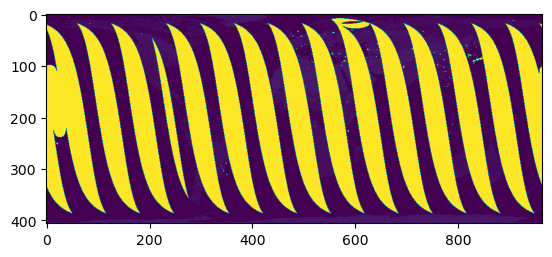

In [139]:
xds_am = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable='landcover_class')
xds_am = xds_am.rename({'band': 'x', 'x':'band'})
xds_am = xds_am.transpose('band', 'y', 'x')
xds_am
IGBPclass_am = xds_am.Soil_Moisture_Retrieval_Data_AM_landcover_class[0].values.transpose()

xds_pm = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_PM', variable='landcover_class_pm')
# In a weird format, need to change coordinate name and transpose
xds_pm = xds_pm.rename({'band': 'x', 'x':'band'})
xds_pm = xds_pm.transpose('band', 'y', 'x')
# Read the most dominant landcover, index=0
IGBPclass_pm = xds_pm.Soil_Moisture_Retrieval_Data_PM_landcover_class_pm[0].values.transpose()